In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("final_data_with_summarization_FinalTesting.csv")

In [ ]:
df

,title,text,label,title_tokens,text_tokens,text_summary
0,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1,13,387,NaN
1,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1,13,477,NaN
2,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,1,18,367,NaN
3,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,1,19,481,NaN
4,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,1,19,454,NaN
...,...,...,...,...,...,...
44893,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,0,19,889,North Korea and the US clashed at a U.N. forum...
44894,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,0,19,889,North Korea and the United States clashed at a...
44895,"U.S., North Korea clash at U.N. arms forum on ...",GENEVA (Reuters) - North Korea and the United ...,0,20,810,North Korea and the US clashed at the United N...
44896,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,0,17,554,Two North Korean shipments to a Syrian governm...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         44898 non-null  object
 1   text          44898 non-null  object
 2   label         44898 non-null  int64 
 3   title_tokens  44898 non-null  int64 
 4   text_tokens   44898 non-null  int64 
 5   text_summary  19248 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.1+ MB


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from textstat import flesch_reading_ease, flesch_kincaid_grade
from scipy.sparse import hstack
from tqdm import tqdm
tqdm.pandas()

Split the dataset + clean up null values

In [ ]:
df = df.dropna(subset=["text"]).copy()  # Prevent null values

# Split train/test first to avoid data leakage
X_raw = df["text"]
y = df["label"]  # 0 = real, 1 = fake

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y
)

Flesch-Kincaid readability calculation

In [ ]:
# Calculate readability features: Flesch Reading Ease & Flesch-Kincaid Grade Level
train_readability = pd.DataFrame({
    "flesch_reading_ease": X_train_raw.progress_apply(flesch_reading_ease),
    "flesch_kincaid_grade": X_train_raw.progress_apply(flesch_kincaid_grade)
}).fillna(0)

test_readability = pd.DataFrame({
    "flesch_reading_ease": X_test_raw.progress_apply(flesch_reading_ease),
    "flesch_kincaid_grade": X_test_raw.progress_apply(flesch_kincaid_grade)
}).fillna(0)

100%|█████████████████████████████████████████████████████████████████████████████| 8980/8980 [00:10<00:00, 845.48it/s]


TF-IDF feature extraction + merge readability features

In [ ]:
# TF-IDF：Unigram + Bigram + Trigram
tfidf = TfidfVectorizer(
    ngram_range=(1, 3),
    max_features=10000,
    stop_words="english"
)
X_train_tfidf = tfidf.fit_transform(X_train_raw)
X_test_tfidf = tfidf.transform(X_test_raw)

# Merge readability and TF-IDF features
X_train = hstack([X_train_tfidf, train_readability.values])
X_test = hstack([X_test_tfidf, test_readability.values])

Logistic regression model training and evaluation

In [ ]:
#Build a logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Prediction and Evaluation
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("Classification Report: ")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))
print(f"ROC AUC score: {roc_auc_score(y_test, y_prob):.4f}")

Classification Report: 
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99      4284
        Fake       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

ROC AUC score: 0.9990


ROC Curve Visualization

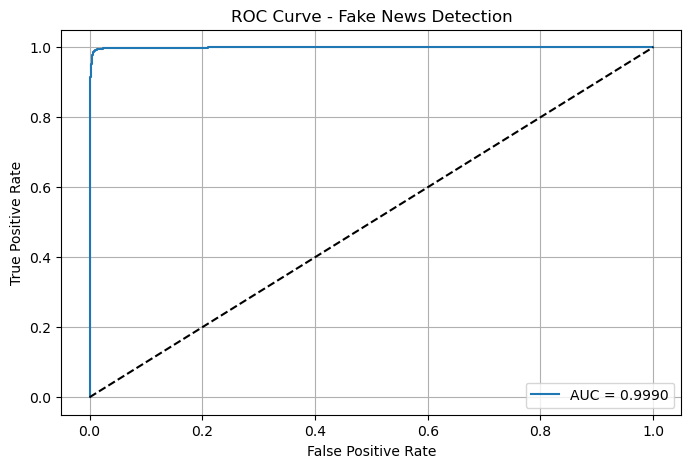

In [ ]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Fake News Detection")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Readability vs. True and False News Visualization

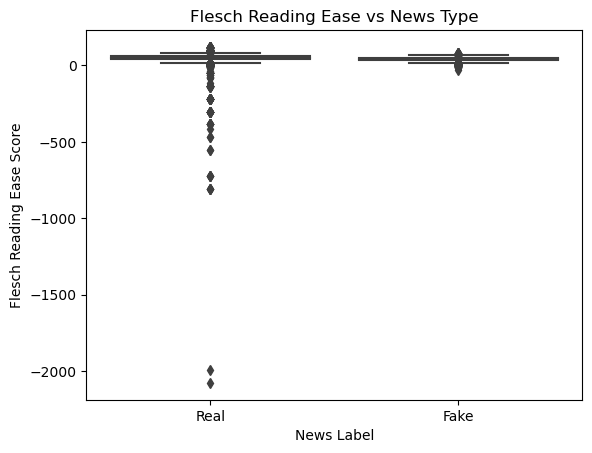

In [ ]:
df['flesch'] = df['text'].apply(flesch_reading_ease)
df['label_text'] = df['label'].map({0: 'Fake', 1: 'Real'})

sns.boxplot(data=df, x='label_text', y='flesch')
plt.title("Flesch Reading Ease vs News Type")
plt.xlabel("News Label")
plt.ylabel("Flesch Reading Ease Score")
plt.show()

Most common word analysis

In [ ]:
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def get_common_words(texts, n=20):
    words = ' '.join(texts).lower().split()
    words = [w for w in words if w.isalpha() and w not in stop_words]
    return Counter(words).most_common(n)

common_fake = get_common_words(df[df['label'] == 0]['text'])
common_real = get_common_words(df[df['label'] == 1]['text'])

print("Fake News Common Words:", common_fake)
print("Real News Common Words:", common_real)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fake News Common Words: [('said', 72035), ('trump', 36485), ('would', 31361), ('president', 23399), ('new', 16578), ('also', 15870), ('state', 15608), ('united', 15521), ('government', 15319), ('house', 14550), ('republican', 14500), ('told', 14221), ('could', 13597), ('last', 12529), ('people', 12400), ('states', 11819), ('one', 11792), ('two', 11279), ('washington', 10785), ('former', 10585)]
Real News Common Words: [('trump', 65511), ('would', 23261), ('people', 22359), ('president', 22080), ('one', 21561), ('said', 21221), ('like', 16858), ('donald', 16800), ('obama', 16043), ('clinton', 15614), ('also', 14771), ('new', 13941), ('even', 13515), ('hillary', 12584), ('white', 12235), ('news', 12123), ('us', 11811), ('state', 10833), ('get', 10603), ('could', 10084)]


In [ ]:
df

,title,text,label,title_tokens,text_tokens,text_summary,flesch,label_text
0,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1,13,387,NaN,45.677700,Real
1,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1,13,477,NaN,62.447143,Real
2,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,1,18,367,NaN,65.023269,Real
3,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,1,19,481,NaN,50.075108,Real
4,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,1,19,454,NaN,45.403077,Real
...,...,...,...,...,...,...,...,...
44893,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,0,19,889,North Korea and the US clashed at a U.N. forum...,45.131802,Fake
44894,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,0,19,889,North Korea and the United States clashed at a...,45.131802,Fake
44895,"U.S., North Korea clash at U.N. arms forum on ...",GENEVA (Reuters) - North Korea and the United ...,0,20,810,North Korea and the US clashed at the United N...,39.594786,Fake
44896,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,0,17,554,Two North Korean shipments to a Syrian governm...,31.903561,Fake


Add emotion tags

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [ ]:
# Read the emotion annotation dataset
sentiment_df = pd.read_csv("news_sentiment_analysis.csv")
sentiment_df = sentiment_df.dropna(subset=["Description", "Sentiment"])

In [ ]:
# Columns
X_sentiment = sentiment_df["Description"]
y_sentiment = sentiment_df["Sentiment"]

# Label Encoding
label_encoder = LabelEncoder()
y_sentiment_encoded = label_encoder.fit_transform(y_sentiment)

# Split data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_sentiment, y_sentiment_encoded, test_size=0.2, random_state=42, stratify=y_sentiment_encoded
)

In [ ]:
# TF-IDF vectorization
sent_vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_vec_s = sent_vectorizer.fit_transform(X_train_s)
X_test_vec_s = sent_vectorizer.transform(X_test_s)

# Train the Naive Bayes model
sentiment_clf = MultinomialNB()
sentiment_clf.fit(X_train_vec_s, y_train_s)

# Validate model
y_pred_s = sentiment_clf.predict(X_test_vec_s)
print(classification_report(y_test_s, y_pred_s, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.85      0.36      0.50       115
     neutral       0.83      0.50      0.62       158
    positive       0.73      0.96      0.83       427

    accuracy                           0.76       700
   macro avg       0.81      0.60      0.65       700
weighted avg       0.78      0.76      0.73       700



In [ ]:
# Predicting Sentiment
X_main_text = df["text"]
X_main_vec = sent_vectorizer.transform(X_main_text)
predicted_sentiment_encoded = sentiment_clf.predict(X_main_vec)
df["predicted_sentiment"] = label_encoder.inverse_transform(predicted_sentiment_encoded)

In [ ]:
df

,title,text,label,title_tokens,text_tokens,text_summary,flesch,label_text,predicted_sentiment
0,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1,13,387,NaN,45.677700,Real,positive
1,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1,13,477,NaN,62.447143,Real,positive
2,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,1,18,367,NaN,65.023269,Real,positive
3,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,1,19,481,NaN,50.075108,Real,positive
4,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,1,19,454,NaN,45.403077,Real,positive
...,...,...,...,...,...,...,...,...,...
44893,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,0,19,889,North Korea and the US clashed at a U.N. forum...,45.131802,Fake,positive
44894,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,0,19,889,North Korea and the United States clashed at a...,45.131802,Fake,positive
44895,"U.S., North Korea clash at U.N. arms forum on ...",GENEVA (Reuters) - North Korea and the United ...,0,20,810,North Korea and the US clashed at the United N...,39.594786,Fake,positive
44896,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,0,17,554,Two North Korean shipments to a Syrian governm...,31.903561,Fake,positive


In [ ]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Contingency table (cross table)
ct = pd.crosstab(df["label"], df["predicted_sentiment"], normalize="index")
print(ct)

predicted_sentiment  negative   neutral  positive
label                                            
0                    0.006163  0.000000  0.993837
1                    0.006516  0.000085  0.993399



Chi-squared test p-value: 0.3596


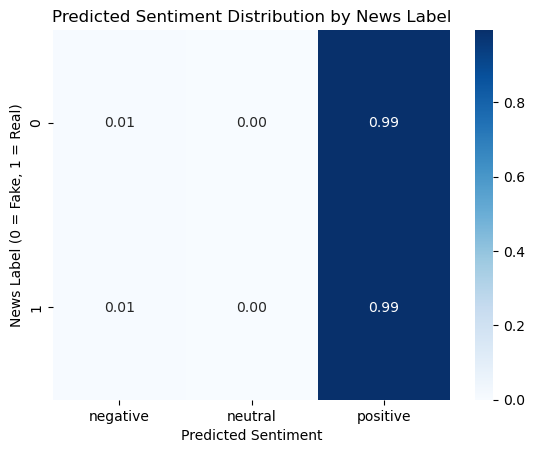

In [ ]:
# Chi-square test
contingency = pd.crosstab(df["label"], df["predicted_sentiment"])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
print(f"\nChi-squared test p-value: {p_value:.4f}")

# Display the proportional distribution graph
sns.heatmap(ct, annot=True, cmap="Blues", fmt=".2f")
plt.title("Predicted Sentiment Distribution by News Label")
plt.xlabel("Predicted Sentiment")
plt.ylabel("News Label (0 = Fake, 1 = Real)")
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
from textstat import flesch_reading_ease, flesch_kincaid_grade
df["flesch_reading_ease"] = df["text"].apply(flesch_reading_ease)
df["flesch_kincaid_grade"] = df["text"].apply(flesch_kincaid_grade)

X_sent_vec = sent_vectorizer.transform(df["text"])
sentiment_proba = sentiment_clf.predict_proba(X_sent_vec)

df_clean = df.dropna(subset=["text", "label", "flesch_reading_ease", "flesch_kincaid_grade"])
y_all = df_clean["label"]

In [ ]:
# Create features
tfidf = TfidfVectorizer(stop_words="english", max_features=10000)
X_tfidf = tfidf.fit_transform(df_clean["text"])
readability = df_clean[["flesch_reading_ease", "flesch_kincaid_grade"]].values
sentiment_proba = sentiment_clf.predict_proba(sent_vectorizer.transform(df_clean["text"]))

from scipy.sparse import hstack
X_all = hstack([X_tfidf, readability, sentiment_proba])
y_all = df_clean["label"]

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))


              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4284
        Real       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
df_main = df.copy()

In [ ]:
# Features
tfidf = TfidfVectorizer(stop_words="english", max_features=10000)
X_tfidf = tfidf.fit_transform(df_clean["text"])
readability = df_clean[["flesch_reading_ease", "flesch_kincaid_grade"]].values
sentiment_proba = sentiment_clf.predict_proba(sent_vectorizer.transform(df_clean["text"]))
y_all = df_clean["label"]

from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# baseline
X_basic = hstack([X_tfidf, readability])
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_basic, y_all, test_size=0.2, random_state=42, stratify=y_all)
clf_basic = LogisticRegression(max_iter=1000)
clf_basic.fit(X_train_b, y_train_b)
y_pred_b = clf_basic.predict(X_test_b)
y_prob_b = clf_basic.predict_proba(X_test_b)[:, 1]

# full model
X_all = hstack([X_tfidf, readability, sentiment_proba])
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)
clf_full = LogisticRegression(max_iter=1000)
clf_full.fit(X_train_f, y_train_f)
y_pred_f = clf_full.predict(X_test_f)
y_prob_f = clf_full.predict_proba(X_test_f)[:, 1]

# Comparison results
print("Model comparison:")
print(f"Baseline Accuracy: {accuracy_score(y_test_b, y_pred_b):.4f}")
print(f"Baseline AUC: {roc_auc_score(y_test_b, y_prob_b):.4f}")
print(f"Full Model Accuracy: {accuracy_score(y_test_f, y_pred_f):.4f}")
print(f"Full Model AUC: {roc_auc_score(y_test_f, y_prob_f):.4f}")

Model comparison:
Baseline Accuracy: 0.9883
Baseline AUC: 0.9986
Full Model Accuracy: 0.9880
Full Model AUC: 0.9986


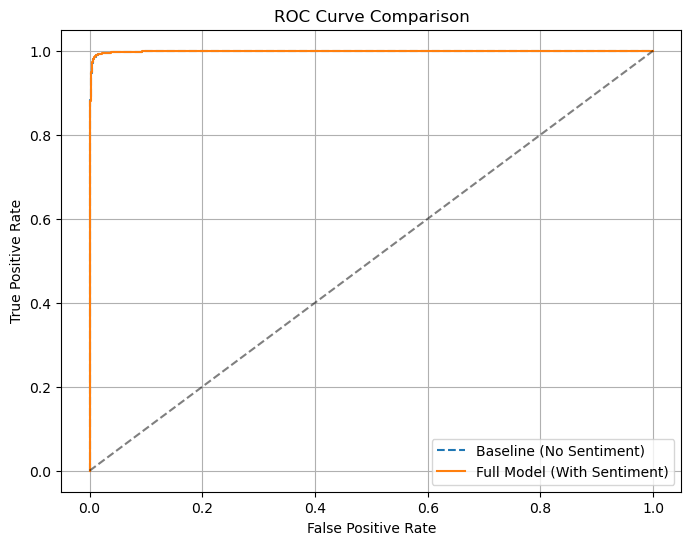

Baseline AUC: 0.9986436795047376
Full Model AUC: 0.9986190742623


In [ ]:
# Clean Data
df_clean = df.dropna(subset=["text", "label", "flesch_reading_ease", "flesch_kincaid_grade"])
y_all = df_clean["label"]

# Feature Construction
tfidf = TfidfVectorizer(stop_words="english", max_features=10000)
X_tfidf = tfidf.fit_transform(df_clean["text"])
readability = df_clean[["flesch_reading_ease", "flesch_kincaid_grade"]].values
sentiment_proba_clean = sentiment_clf.predict_proba(sent_vectorizer.transform(df_clean["text"]))

X_basic = hstack([X_tfidf, readability])
X_all = hstack([X_tfidf, readability, sentiment_proba_clean])

# Create Baseline Model
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_basic, y_all, test_size=0.2, random_state=42, stratify=y_all)
clf_b = LogisticRegression(max_iter=1000)
clf_b.fit(X_train_b, y_train_b)
y_prob_b = clf_b.predict_proba(X_test_b)[:, 1]

# Create a Full model (including emotional probability)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)
clf_f = LogisticRegression(max_iter=1000)
clf_f.fit(X_train_f, y_train_f)
y_prob_f = clf_f.predict_proba(X_test_f)[:, 1]

# Draw ROC curves
fpr_b, tpr_b, _ = roc_curve(y_test_b, y_prob_b)
fpr_f, tpr_f, _ = roc_curve(y_test_f, y_prob_f)

plt.figure(figsize=(8, 6))
plt.plot(fpr_b, tpr_b, label="Baseline (No Sentiment)", linestyle="--")
plt.plot(fpr_f, tpr_f, label="Full Model (With Sentiment)")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print out additional AUC scores
print("Baseline AUC:", roc_auc_score(y_test_b, y_prob_b))
print("Full Model AUC:", roc_auc_score(y_test_f, y_prob_f))

In [ ]:
# Read and merge test set
df_fake = pd.read_csv("Fake.csv")
df_real = pd.read_csv("True.csv")
df_fake["label"] = 0
df_real["label"] = 1
df_test = pd.concat([df_fake, df_real], ignore_index=True)
df_test = df_test.dropna(subset=["text", "label"]).copy()

# Create test set features
df_test["flesch_reading_ease"] = df_test["text"].apply(flesch_reading_ease)
df_test["flesch_kincaid_grade"] = df_test["text"].apply(flesch_kincaid_grade)
X_test_tfidf = tfidf.transform(df_test["text"])
X_test_read = df_test[["flesch_reading_ease", "flesch_kincaid_grade"]].values
X_test_sent = sent_vectorizer.transform(df_test["text"])
X_test_sent_proba = sentiment_clf.predict_proba(X_test_sent)
X_test_final = hstack([X_test_tfidf, X_test_read, X_test_sent_proba])
y_test_final = df_test["label"]

# Model prediction and evaluation
y_pred = clf_full.predict(X_test_final)
y_prob = clf_full.predict_proba(X_test_final)[:, 1]
print(classification_report(y_test_final, y_pred, target_names=["Fake", "Real"]))
print("Accuracy:", accuracy_score(y_test_final, y_pred))
print("AUC:", roc_auc_score(y_test_final, y_prob))

              precision    recall  f1-score   support

        Fake       0.01      0.01      0.01     23481
        Real       0.01      0.01      0.01     21417

    accuracy                           0.01     44898
   macro avg       0.01      0.01      0.01     44898
weighted avg       0.01      0.01      0.01     44898

Accuracy: 0.00955499131364426
AUC: 0.0009086015998203893
